In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import folium
import geopandas as gpd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import itertools
from folium.plugins import MarkerCluster
import re
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde
import time
from shapely.geometry import Point
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

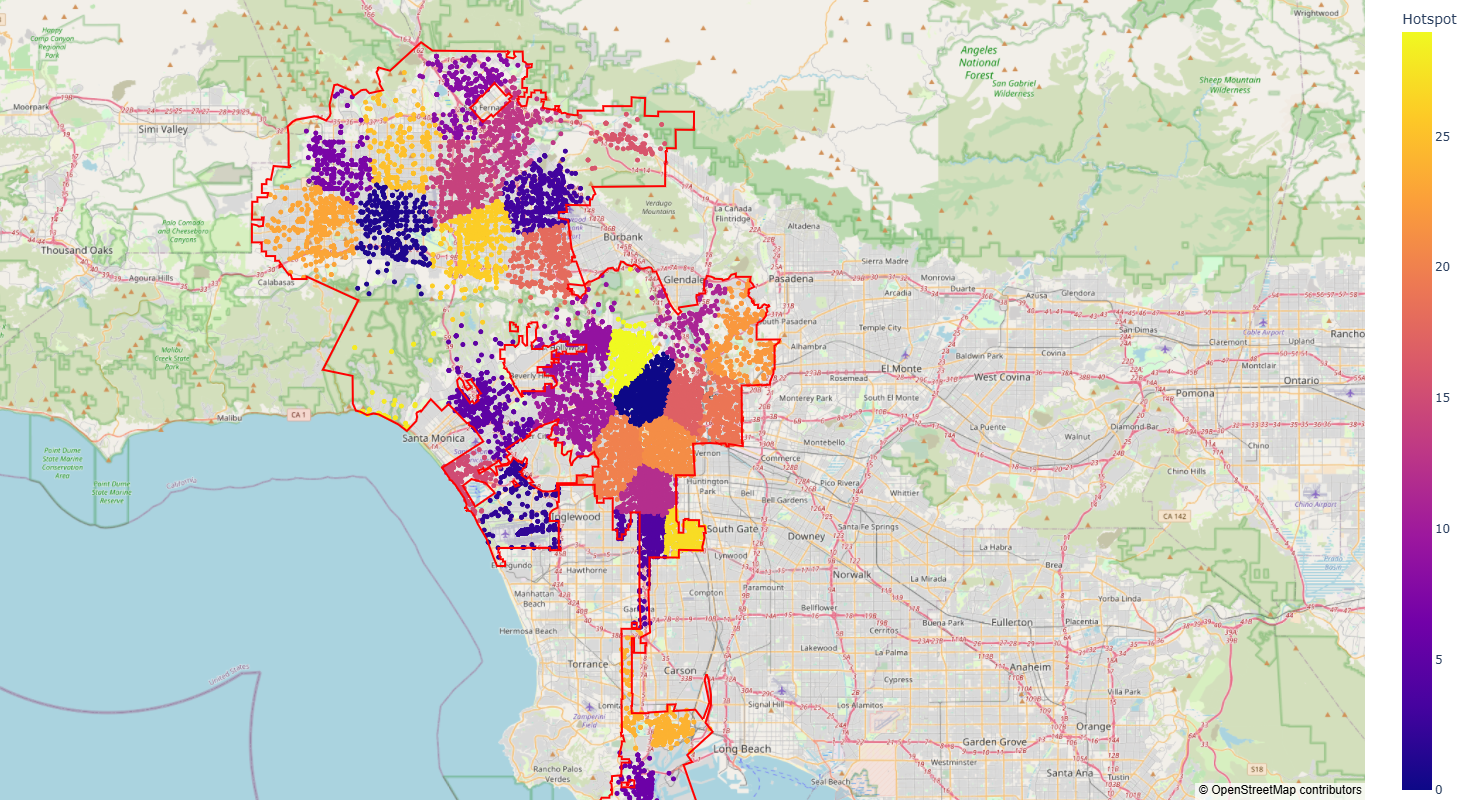

In [8]:
# kmeans_spatial_clustering.py

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import json

# Load the data
df = pd.read_csv("Time_formatted_fixed_loc.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df[['Datetime', 'LAT', 'LON']].dropna()

# Standardize LAT and LON
scaler = StandardScaler()
df[['LAT_std', 'LON_std']] = scaler.fit_transform(df[['LAT', 'LON']])

# KMeans on standardized coordinates
kmeans = KMeans(n_clusters=30, random_state=42)
df['Hotspot'] = kmeans.fit_predict(df[['LAT_std', 'LON_std']])

# Load LA boundary GeoJSON
with open("la_boundary.geojson", "r") as f:
    la_boundary = json.load(f)

# Visualize using original coordinates
fig = px.scatter_mapbox(
    df.sample(frac=0.05, random_state=42),
    lat="LAT",
    lon="LON",
    color="Hotspot",
    zoom=9.5,
    center={"lat": 34.05, "lon": -118.25},
    height=800
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {"source": la_boundary, "type": "line", "color": "red"},
    ],
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()


# Kmeans Clustering 30

In [9]:
df['Hotspot'].value_counts()

Hotspot
0     34425
17    30484
12    20168
21    16689
9     16572
26    16187
29    15879
14    14758
20    14127
10    12388
23    11637
18    11240
5      9920
4      9823
15     9642
2      9617
3      9463
1      8418
19     8392
7      7661
13     7198
22     6967
27     6266
8      5493
24     5439
25     4912
6      4590
11     3962
16     1491
28      748
Name: count, dtype: int64

In [10]:
df['Date'] = df['Datetime'].dt.to_period('W').apply(lambda r: r.start_time)
time_series = df.groupby(['Date', 'Hotspot']).size().reset_index(name='CrimeCount')
ts_pivot = time_series.pivot(index='Date', columns='Hotspot', values='CrimeCount').fillna(0)
ts_pivot = ts_pivot.sort_index()
ts_pivot.index = pd.DatetimeIndex(ts_pivot.index, freq='W-MON')

In [11]:
ts_pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2019-12-30 to 2025-01-27
Freq: W-MON
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       266 non-null    float64
 1   1       266 non-null    float64
 2   2       266 non-null    float64
 3   3       266 non-null    float64
 4   4       266 non-null    float64
 5   5       266 non-null    float64
 6   6       266 non-null    float64
 7   7       266 non-null    float64
 8   8       266 non-null    float64
 9   9       266 non-null    float64
 10  10      266 non-null    float64
 11  11      266 non-null    float64
 12  12      266 non-null    float64
 13  13      266 non-null    float64
 14  14      266 non-null    float64
 15  15      266 non-null    float64
 16  16      266 non-null    float64
 17  17      266 non-null    float64
 18  18      266 non-null    float64
 19  19      266 non-null    float64
 20  20      266 non-null    float64
 21  21      

In [144]:
ts_pivot.value_counts()

0      1     2     3     4     5     6     7     8     9     10    11    12    13    14    15     16   17     18    19    20    21    22    23    24    25    26    27    28   29  
326.0  22.0  19.0  40.0  43.0  28.0  15.0  37.0  17.0  63.0  95.0  21.0  72.0  30.0  66.0  61.0   5.0  165.0  92.0  44.0  61.0  47.0  41.0  40.0  10.0  19.0  50.0  21.0  2.0  83.0    1
39.0   27.0  36.0  22.0  24.0  9.0   15.0  21.0  11.0  42.0  32.0  6.0   67.0  18.0  50.0  34.0   2.0  82.0   28.0  19.0  31.0  66.0  17.0  37.0  16.0  11.0  57.0  29.0  0.0  26.0    1
42.0   15.0  24.0  17.0  17.0  14.0  13.0  17.0  14.0  42.0  32.0  4.0   36.0  16.0  28.0  6.0    5.0  94.0   30.0  25.0  23.0  31.0  20.0  21.0  17.0  12.0  39.0  11.0  7.0  36.0    1
47.0   19.0  26.0  26.0  10.0  23.0  6.0   9.0   14.0  31.0  37.0  8.0   37.0  26.0  34.0  11.0   2.0  92.0   14.0  15.0  32.0  36.0  16.0  15.0  15.0  10.0  52.0  8.0   0.0  41.0    1
49.0   35.0  26.0  14.0  30.0  28.0  13.0  13.0  25.0  38.0  51.0  10.0  70.0  1

### Timeseries Plot 

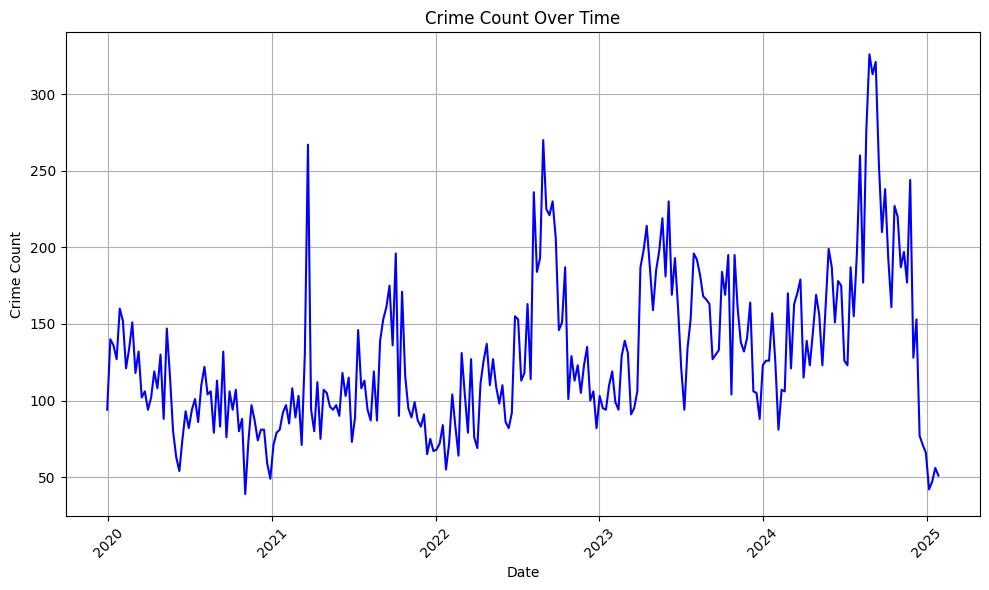

In [145]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[0], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ACF Plot

<Figure size 1000x500 with 0 Axes>

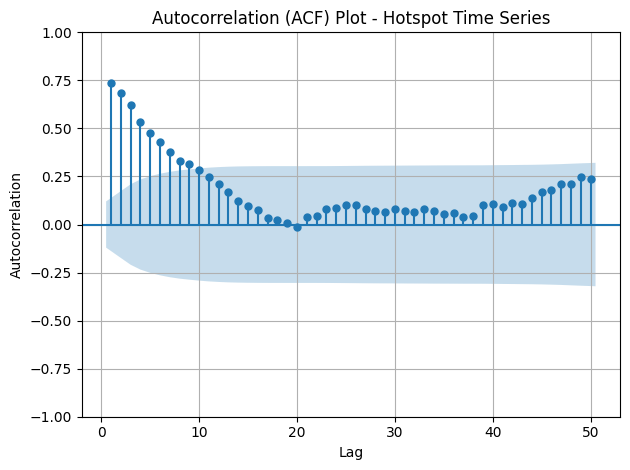

In [146]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[0].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

### ADF Test

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

# === Load Time Series Data ===
# Example: ts_pivot should be a DataFrame with datetime index and hotspot series as columns
# You should replace this with actual loading logic
# ts_pivot = pd.read_csv("your_timeseries.csv", index_col=0, parse_dates=True)
hotspot_series = ts_pivot[0].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.9)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")

== ADF Stationarity Test ==
ADF Statistic: -3.5098
p-value: 0.0077
=> Stationary


# Models

### Auto Regression

In [91]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

print(f"hotspot_scaled shape: {hotspot_scaled.shape}")
print(f"Test data shape: {test_data.shape}")

best_ar_rmse = float('inf')
best_ar_lag = None
best_ar_actual = None
best_ar_pred = None

# --- AutoRegressive Model ---
for lag in range(1, 40):
    if len(train_data) <= lag:
        print(f"Skipping lag {lag} due to insufficient training data.")
        continue

    try:
        # Fit model on training data
        model_ar = AutoReg(train_data, lags=lag, old_names=False).fit()

        # Forecast for the test period
        pred_ar_scaled = model_ar.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

        # Inverse transform
        pred_ar = inverse_transform(pred_ar_scaled)
        actual_ar = inverse_transform(test_data)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(actual_ar, pred_ar))
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred_ar
            best_ar_actual = actual_ar
    except Exception as e:
        print(f"Error for lag {lag}: {e}")
        continue

# --- Output Results ---
if best_ar_lag is not None:
    print(f"Best AR Lag: {best_ar_lag}")
    print(f"AR RMSE: {best_ar_rmse:.2f}")
    print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred) * 100:.2f}%")
else:
    print("No valid AR model was found.")


hotspot_scaled shape: (266,)
Test data shape: (54,)
Best AR Lag: 39
AR RMSE: 71.41
AR MAPE: 40.39%


### SARIMA

In [92]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

# --- Define parameter ranges for SARIMA ---
p = d = q = range(0, 3)  # Non-seasonal params
P = D = Q = range(0, 2)  # Seasonal params
s = 12  # Seasonal period (adjust if needed)

best_sarima_rmse = float('inf')
best_seasonal_order = None
best_order_sarima = None
best_sarima_pred = None
best_sarima_actual = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            # Fit SARIMA model on training data
            model_sarima = SARIMAX(train_data,
                                   order=order,
                                   seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit(disp=False)

            # Forecast for test data length
            pred_sarima_scaled = model_sarima.forecast(steps=len(test_data))

            # Inverse transform
            pred_sarima = inverse_transform(pred_sarima_scaled)
            actual_sarima = inverse_transform(test_data)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(actual_sarima, pred_sarima))

            # Update best model
            if rmse < best_sarima_rmse:
                best_sarima_rmse = rmse
                best_order_sarima = order
                best_seasonal_order = seasonal_order
                best_sarima_pred = pred_sarima
                best_sarima_actual = actual_sarima
        except Exception as e:
            print(f"Error for order {order} seasonal {seasonal_order}: {e}")
            continue

# --- Output Best SARIMA Model ---
if best_order_sarima is not None:
    print(f"Best SARIMA Order: {best_order_sarima}, Seasonal: {best_seasonal_order} x {s}")
    print(f"SARIMA RMSE: {best_sarima_rmse:.2f}")
    print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_sarima_actual, best_sarima_pred) * 100:.2f}%")
else:
    print("No valid SARIMA model was found.")


Best SARIMA Order: (2, 1, 2), Seasonal: (0, 1, 1) x 12
SARIMA RMSE: 66.77
SARIMA MAPE: 44.69%


### SARIMA with Karimann filtering


For lag = 1
Test RMSE: 42.4966
MAPE: 22.02%

For lag = 2
Test RMSE: 40.2943
MAPE: 21.20%

For lag = 3
Test RMSE: 40.3150
MAPE: 21.96%

For lag = 4
Test RMSE: 40.7781
MAPE: 22.26%

For lag = 6
Test RMSE: 41.3941
MAPE: 23.48%

For lag = 9
Test RMSE: 41.7257
MAPE: 25.03%

For lag = 12
Test RMSE: 41.9549
MAPE: 25.07%

For lag = 16
Test RMSE: 44.7594
MAPE: 27.38%

For lag = 24
Test RMSE: 44.1419
MAPE: 26.69%

For lag = 30
Test RMSE: 44.0932
MAPE: 26.57%

For lag = 40
Test RMSE: 43.0040
MAPE: 26.30%

For lag = 50
Test RMSE: 44.3584
MAPE: 26.27%


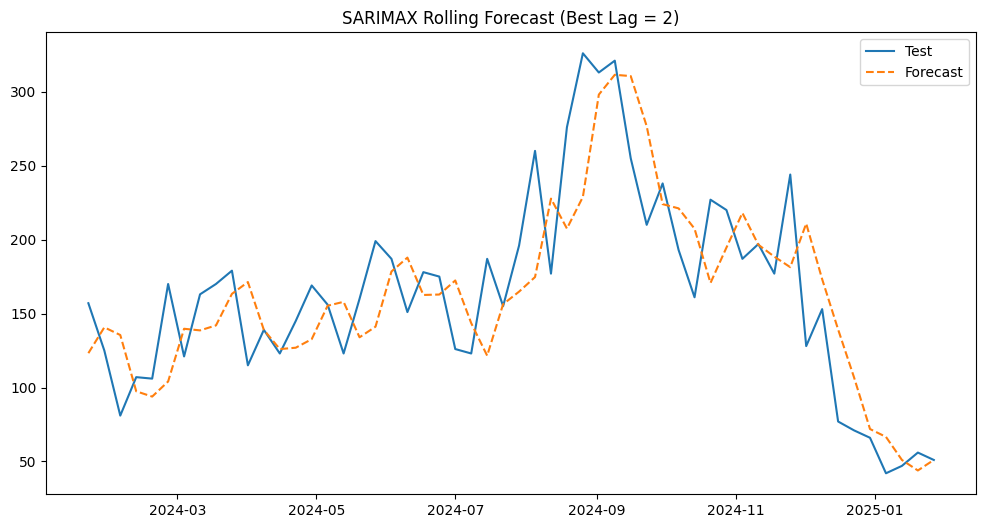

In [89]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[0].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


###

### LSTM 

Epoch 1, Loss: 0.1628
Epoch 2, Loss: 0.1228
Epoch 3, Loss: 0.1125
Epoch 4, Loss: 0.1157
Epoch 5, Loss: 0.1266
Epoch 6, Loss: 0.1076
Epoch 7, Loss: 0.1000
Epoch 8, Loss: 0.1096
Epoch 9, Loss: 0.0955
Epoch 10, Loss: 0.0902
Epoch 11, Loss: 0.1004
Epoch 12, Loss: 0.0880
Epoch 13, Loss: 0.0888
Epoch 14, Loss: 0.0956
Epoch 15, Loss: 0.0883
Epoch 16, Loss: 0.0814
Epoch 17, Loss: 0.0916
Epoch 18, Loss: 0.0890
Epoch 19, Loss: 0.0808
Epoch 20, Loss: 0.0869
Epoch 21, Loss: 0.0910
Epoch 22, Loss: 0.0838
Epoch 23, Loss: 0.0852
Epoch 24, Loss: 0.0830
Epoch 25, Loss: 0.0823
Epoch 26, Loss: 0.0853
Epoch 27, Loss: 0.0810
Epoch 28, Loss: 0.0847
Epoch 29, Loss: 0.0837
Epoch 30, Loss: 0.0841
Epoch 31, Loss: 0.0911
Epoch 32, Loss: 0.0810
Epoch 33, Loss: 0.0936
Epoch 34, Loss: 0.0780
Epoch 35, Loss: 0.0788
Epoch 36, Loss: 0.0899
Epoch 37, Loss: 0.0809
Epoch 38, Loss: 0.0796
Epoch 39, Loss: 0.0852
Epoch 40, Loss: 0.0833
Epoch 41, Loss: 0.0775
Epoch 42, Loss: 0.0786
Epoch 43, Loss: 0.0842
Epoch 44, Loss: 0.08

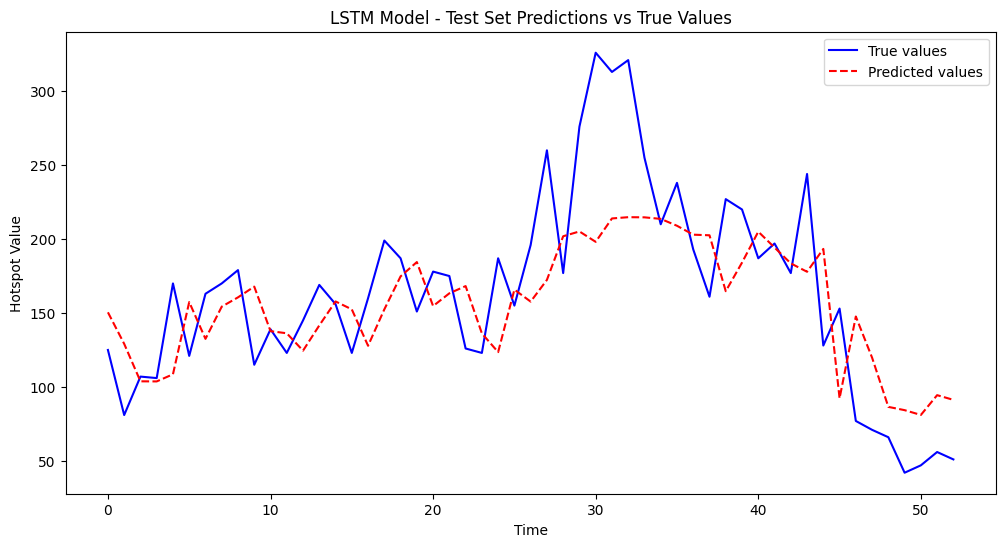

Test RMSE: 46.3981
Test MAPE: 26.90%


In [90]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=2):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")


In [5]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[0].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 54.42
XGBoost MAPE: 29.88%


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



# For Cluster 17

# Timeseries Plot

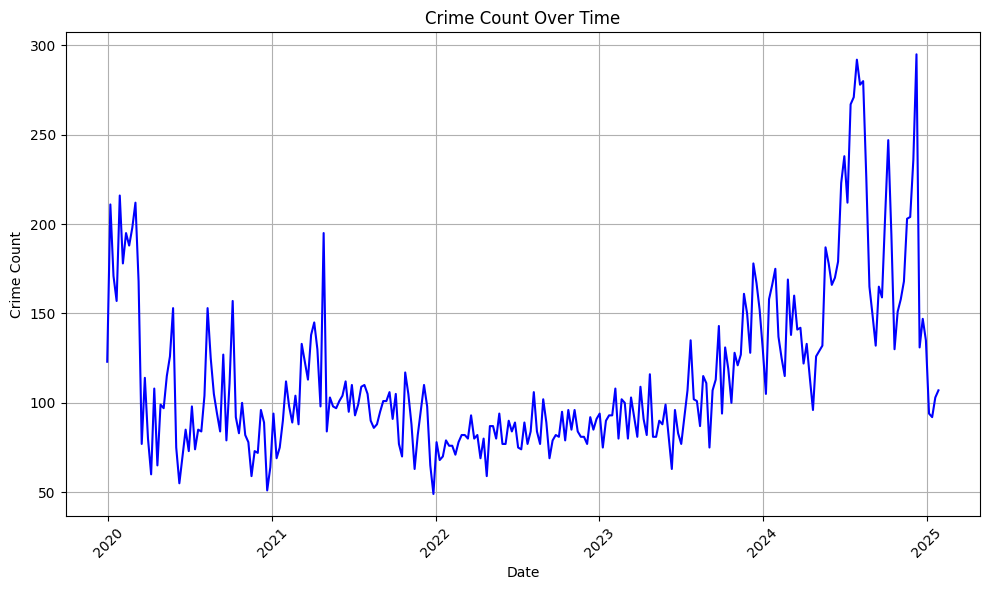

In [99]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[17], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [107]:
# ACF Plot

<Figure size 1000x500 with 0 Axes>

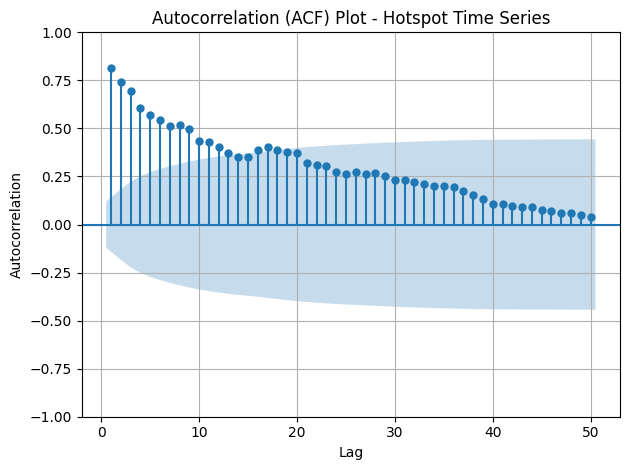

In [100]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[17].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

# ATF Test

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

# === Load Time Series Data ===
# Example: ts_pivot should be a DataFrame with datetime index and hotspot series as columns
# You should replace this with actual loading logic
# ts_pivot = pd.read_csv("your_timeseries.csv", index_col=0, parse_dates=True)
hotspot_series = ts_pivot[17].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.9)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")

== ADF Stationarity Test ==
ADF Statistic: -1.2811
p-value: 0.6378
=> Non-Stationary


### Auto Regression

In [103]:
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Preprocessing ---
hotspot_series = ts_pivot[17].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

print(f"hotspot_scaled shape: {hotspot_scaled.shape}")
print(f"Test data shape: {test_data.shape}")

best_ar_rmse = float('inf')
best_ar_lag = None
best_ar_actual = None
best_ar_pred = None

# --- AutoRegressive Model ---
for lag in range(1, 40):
    if len(train_data) <= lag:
        print(f"Skipping lag {lag} due to insufficient training data.")
        continue

    try:
        # Fit model on training data
        model_ar = AutoReg(train_data, lags=lag, old_names=False).fit()

        # Forecast for the test period
        pred_ar_scaled = model_ar.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

        # Inverse transform
        pred_ar = inverse_transform(pred_ar_scaled)
        actual_ar = inverse_transform(test_data)

        # Evaluate
        rmse = np.sqrt(mean_squared_error(actual_ar, pred_ar))
        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred_ar
            best_ar_actual = actual_ar
    except Exception as e:
        print(f"Error for lag {lag}: {e}")
        continue

# --- Output Results ---
if best_ar_lag is not None:
    print(f"Best AR Lag: {best_ar_lag}")
    print(f"AR RMSE: {best_ar_rmse:.2f}")
    print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred) * 100:.2f}%")
else:
    print("No valid AR model was found.")


hotspot_scaled shape: (266,)
Test data shape: (54,)
Best AR Lag: 31
AR RMSE: 66.87
AR MAPE: 25.01%


# SARIMA

In [104]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# --- Preprocessing ---
hotspot_series = ts_pivot[17].values.reshape(-1, 1)

# Normalize the data to scale it between 0 and 1
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series).flatten()

# --- Train/test split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train_data, test_data = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1, 1)).flatten()

# Suppress all warnings
warnings.filterwarnings('ignore')

# --- Define parameter ranges for SARIMA ---
p = d = q = range(0, 3)  # Non-seasonal params
P = D = Q = range(0, 2)  # Seasonal params
s = 12  # Seasonal period (adjust if needed)

best_sarima_rmse = float('inf')
best_seasonal_order = None
best_order_sarima = None
best_sarima_pred = None
best_sarima_actual = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            # Fit SARIMA model on training data
            model_sarima = SARIMAX(train_data,
                                   order=order,
                                   seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit(disp=False)

            # Forecast for test data length
            pred_sarima_scaled = model_sarima.forecast(steps=len(test_data))

            # Inverse transform
            pred_sarima = inverse_transform(pred_sarima_scaled)
            actual_sarima = inverse_transform(test_data)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(actual_sarima, pred_sarima))

            # Update best model
            if rmse < best_sarima_rmse:
                best_sarima_rmse = rmse
                best_order_sarima = order
                best_seasonal_order = seasonal_order
                best_sarima_pred = pred_sarima
                best_sarima_actual = actual_sarima
        except Exception as e:
            print(f"Error for order {order} seasonal {seasonal_order}: {e}")
            continue

# --- Output Best SARIMA Model ---
if best_order_sarima is not None:
    print(f"Best SARIMA Order: {best_order_sarima}, Seasonal: {best_seasonal_order} x {s}")
    print(f"SARIMA RMSE: {best_sarima_rmse:.2f}")
    print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_sarima_actual, best_sarima_pred) * 100:.2f}%")
else:
    print("No valid SARIMA model was found.")


Best SARIMA Order: (0, 2, 1), Seasonal: (0, 0, 1) x 12
SARIMA RMSE: 53.40
SARIMA MAPE: 25.59%


### SARIMA with Karimann filtering


For lag = 1
Test RMSE: 36.5196
MAPE: 15.82%

For lag = 2
Test RMSE: 37.9105
MAPE: 17.37%

For lag = 3
Test RMSE: 40.0383
MAPE: 19.18%

For lag = 4
Test RMSE: 40.1028
MAPE: 19.19%

For lag = 6
Test RMSE: 39.8776
MAPE: 19.15%

For lag = 9
Test RMSE: 38.8343
MAPE: 18.96%

For lag = 12
Test RMSE: 40.3829
MAPE: 19.78%

For lag = 16
Test RMSE: 45.4023
MAPE: 23.46%

For lag = 24
Test RMSE: 45.9003
MAPE: 23.64%

For lag = 30
Test RMSE: 45.9494
MAPE: 23.96%

For lag = 40
Test RMSE: 44.2970
MAPE: 23.67%

For lag = 50
Test RMSE: 47.8719
MAPE: 25.19%


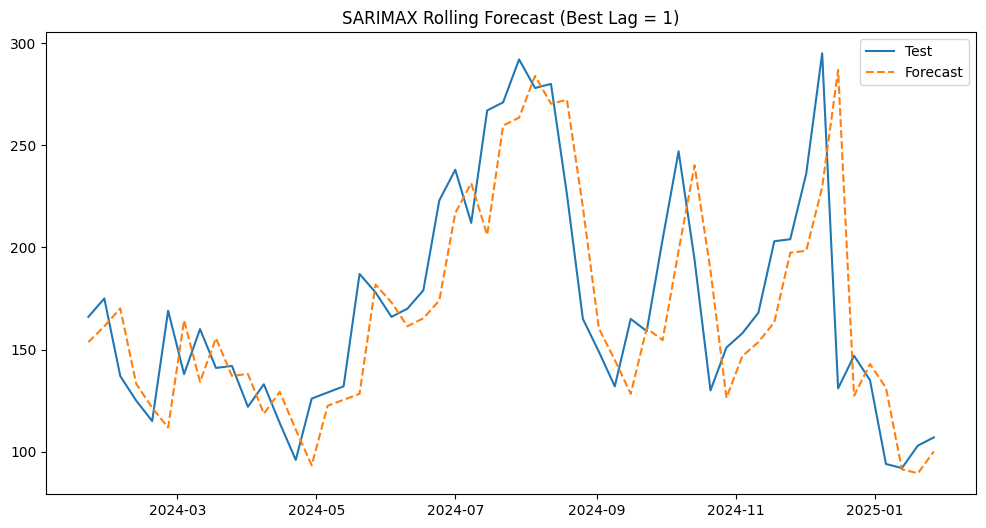

In [105]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[17].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


### LSTM

Epoch 1, Loss: 0.1450
Epoch 2, Loss: 0.1168
Epoch 3, Loss: 0.1166
Epoch 4, Loss: 0.1130
Epoch 5, Loss: 0.1168
Epoch 6, Loss: 0.1142
Epoch 7, Loss: 0.0992
Epoch 8, Loss: 0.0902
Epoch 9, Loss: 0.0915
Epoch 10, Loss: 0.0893
Epoch 11, Loss: 0.0937
Epoch 12, Loss: 0.0881
Epoch 13, Loss: 0.0833
Epoch 14, Loss: 0.0882
Epoch 15, Loss: 0.0870
Epoch 16, Loss: 0.0812
Epoch 17, Loss: 0.0853
Epoch 18, Loss: 0.0979
Epoch 19, Loss: 0.0898
Epoch 20, Loss: 0.0869
Epoch 21, Loss: 0.0863
Epoch 22, Loss: 0.0790
Epoch 23, Loss: 0.0835
Epoch 24, Loss: 0.0792
Epoch 25, Loss: 0.0885
Epoch 26, Loss: 0.0873
Epoch 27, Loss: 0.0776
Epoch 28, Loss: 0.0826
Epoch 29, Loss: 0.0810
Epoch 30, Loss: 0.0793
Epoch 31, Loss: 0.0861
Epoch 32, Loss: 0.0854
Epoch 33, Loss: 0.0878
Epoch 34, Loss: 0.0886
Epoch 35, Loss: 0.0875
Epoch 36, Loss: 0.0878
Epoch 37, Loss: 0.0792
Epoch 38, Loss: 0.0788
Epoch 39, Loss: 0.0779
Epoch 40, Loss: 0.0773
Epoch 41, Loss: 0.0848
Epoch 42, Loss: 0.0881
Epoch 43, Loss: 0.0918
Epoch 44, Loss: 0.08

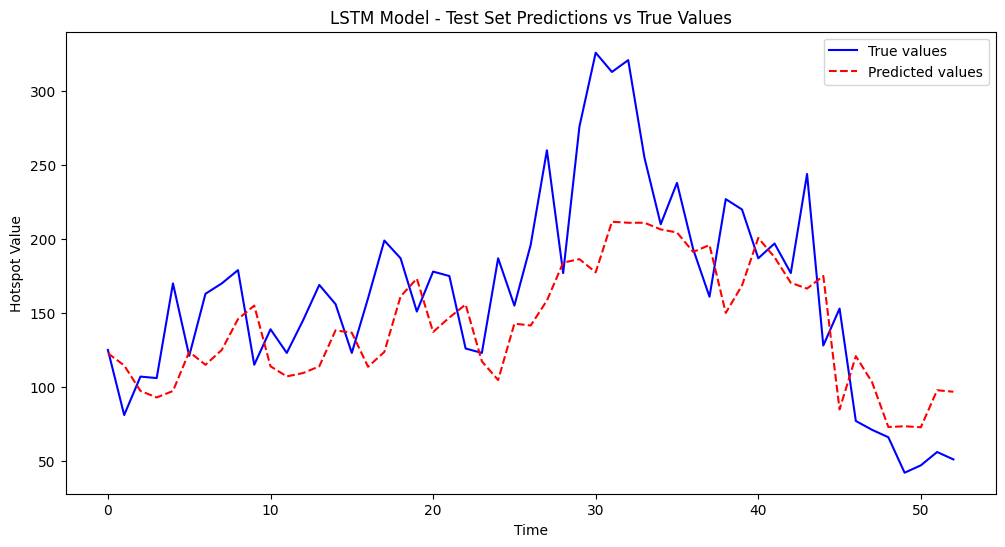

Test RMSE: 51.2106
Test MAPE: 26.56%


In [106]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=2):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")


### xgboost

In [6]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[17].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 74.57
XGBoost MAPE: 28.74%


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

